In [1]:
import numpy as np
import pandas as pd
import pandas as pd
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer
import torch
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#%pip install seaborn

# Data Quality Evaluation

In this notebook we want to explore the synthetic positive pairs dataset

In [3]:
df = pd.read_csv('../synth_set/synthetic_positive_pairs.tsv', sep='\t')
df.sample(n=100, random_state=119).to_csv('inspect_top100.tsv', sep='\t')

In [4]:
print("NaN values in 'query':", df['query'].isna().sum())
print("NaN values in 'document':", df['product_text'].isna().sum())
df.dropna(inplace=True)
df.head()

NaN values in 'query': 1
NaN values in 'document': 0


,query,product_text,relevance_label,id
0,toddler 115mm polarized,INNOCHEER Party Sunglasses for Kids with UV400...,1,750355
1,plastic star favor,INNOCHEER Party Sunglasses for Kids with UV400...,1,750355
2,tina belcher glasses,INNOCHEER Party Sunglasses for Kids with UV400...,1,750355
3,plastic star wars hat,INNOCHEER Party Sunglasses for Kids with UV400...,1,750355
4,sxs lift table,Vestil A-LIFT-DK Deck Platform for Hand Winch ...,1,774564


**Evaluate Diversity of Queries and Documents**

- **Vocabulary Diversity**: Check the diversity of vocabulary across your queries and documents. High diversity typically indicates that your dataset covers a wide range of topics, which can be desirable in some applications.
- **TF-IDF Analysis**: Using TF-IDF scores, you can identify the most distinctive terms for queries and documents. If the high-weight terms for each query are consistently present in the corresponding document, its a good sign for relevance.


In [5]:
# Step 1: Vocabulary Diversity
# Measure unique vocabulary in queries and product_text
query_vocab = set(" ".join(df['query']).split())
product_text_vocab = set(" ".join(df['product_text']).split())

query_vocab_size = len(query_vocab)
product_text_vocab_size = len(product_text_vocab)

# Ratio of unique terms in queries to documents
vocab_diversity_ratio = query_vocab_size / product_text_vocab_size

print(f"Query Vocabulary Size: {query_vocab_size}")
print(f"Product Text Vocabulary Size: {product_text_vocab_size}")
print(f"Vocabulary Diversity Ratio (query/document): {vocab_diversity_ratio}")

# Step 2: TF-IDF Analysis
# We'll use a subset of data if the set is too large, e.g., first 100,000 rows
subset_data = df.sample(100_000, random_state=119)

# Fit TF-IDF on combined corpus of queries and product_text
combined_corpus = pd.concat([subset_data['query'], subset_data['product_text']])
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(combined_corpus)

# Transform both queries and product_text using the same fitted vocabulary
tfidf_queries = tfidf_vectorizer.transform(subset_data['query'])
tfidf_products = tfidf_vectorizer.transform(subset_data['product_text'])

# Calculate cosine similarity
cosine_similarities = cosine_similarity(tfidf_queries, tfidf_products)

# Average cosine similarity (indicates the general relevance across the subset)
average_cosine_similarity = np.mean([cosine_similarities[i, i] for i in range(len(cosine_similarities))])

print(f"Average Cosine Similarity between queries and documents: {average_cosine_similarity}")

# Step 3: Analyzing High-Weight Terms
# For queries, identify the most significant TF-IDF terms (features with highest weights)
feature_names = tfidf_vectorizer.get_feature_names_out()
top_n_terms = 10  # Define how many top terms you want to inspect for each

# Extract the top terms for the first 10 samples to understand diversity
for i in range(10):
    row = tfidf_queries[i].tocoo()
    top_indices = row.col[np.argsort(row.data)[-top_n_terms:]]
    top_terms = [feature_names[index] for index in top_indices]
    print(f"Top terms for query {subset_data['query'].iloc[i]}: {top_terms}")

Query Vocabulary Size: 53701
Product Text Vocabulary Size: 1821431
Vocabulary Diversity Ratio (query/document): 0.02948286265030078
Average Cosine Similarity between queries and documents: 0.17839936047933475
Top terms for query humidifier without filter: ['without', 'filter', 'humidifier']
Top terms for query step in bike basket coupler: ['in', 'step', 'bike', 'basket', 'coupler']
Top terms for query 1 in pvc: ['in', 'pvc']
Top terms for query open when letters kit: ['when', 'kit', 'open', 'letters']
Top terms for query garden gate: ['garden', 'gate']
Top terms for query pink hair pins: ['pink', 'hair', 'pins']
Top terms for query 1/2 inch curling iron for hair: ['for', 'inch', 'hair', 'iron', 'curling']
Top terms for query wide calf combat boots for women: ['for', 'women', 'wide', 'boots', 'combat', 'calf']
Top terms for query 12 inch carabiner rod: ['inch', '12', 'rod', 'carabiner']
Top terms for query zip up nightgowns for women: ['for', 'up', 'women', 'zip', 'nightgowns']


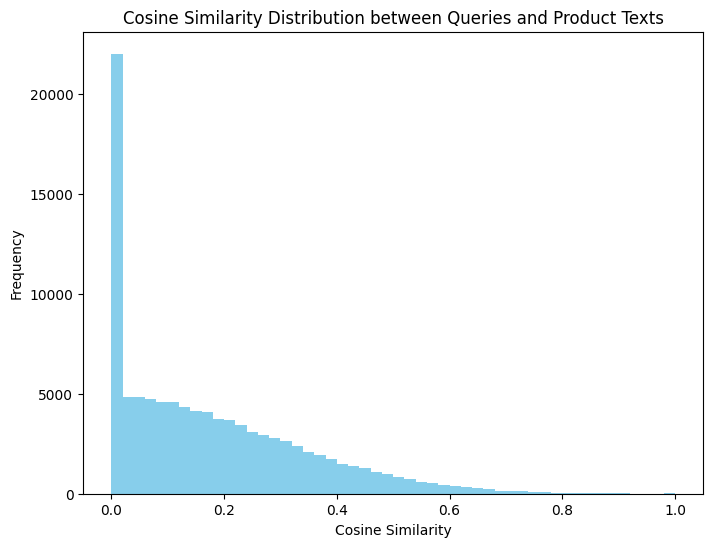

In [6]:
plt.figure(figsize=(8, 6))
plt.hist(cosine_similarities.diagonal(), bins=50, color='skyblue')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.title('Cosine Similarity Distribution between Queries and Product Texts')
plt.show()

**Assess Quality with Statistical Measures**

- **Distribution of Query Lengths**: Calculate the average, median, and standard deviation of query lengths. Unnaturally short or long queries might indicate issues with the synthetic generation process.
- **Term Frequency Analysis**: Examine term frequency distributions within queries and documents. If certain terms appear unusually often, this might indicate issues with the generation process, such as repetitive or uninformative text.

In [5]:
df['query_length'] = df['query'].apply(len)
df['product_text_length'] = df['product_text'].apply(len)

print("Average query length:", df['query_length'].mean())
print("Average document length:", df['product_text_length'].mean())
print("Query length standard deviation:", df['query_length'].std())

Average query length: 22.077915593738837
Average document length: 1630.6082290518743
Query length standard deviation: 8.495691340668827


**Embedding Similarity**

Compute similarity scores (e.g., cosine similarity) between query and document embeddings. If they are supposed to be relevant pairs, embeddings should be closer in vector space.

We load the precomputed embeddings from GTE-en-large-v1.5

count    290016.000000
mean          0.643556
std           0.095470
min           0.149147
25%           0.585007
50%           0.651598
75%           0.709024
max           1.000000
Name: cosine_similarity, dtype: float64


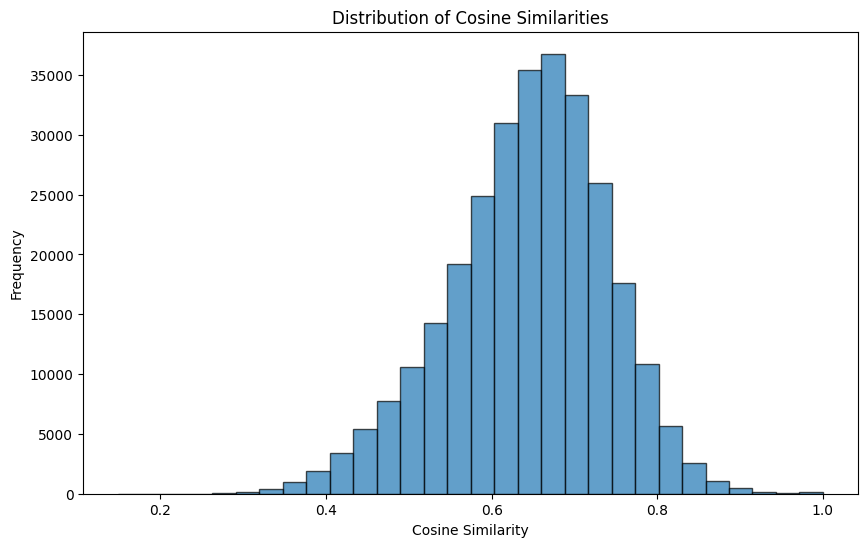

In [2]:
df = pd.read_parquet('../synth_set/synthetic_positive_pairs.parquet.gzip')
df = pd.merge(df, pd.read_pickle('../p_collection.pkl'), on='id')
df.dropna(subset=['query', 'product_embedding'], inplace=True)
df = df.sample(frac=0.2, random_state=119)

# Convert embeddings to arrays
df['product_embedding'] = df['product_embedding'].apply(np.array)
df['query_embedding'] = df['query_embedding'].apply(np.array)

# Define batch size
batch_size = 500  # Adjust based on available memory
cosine_similarities = []

# Calculate cosine similarity in batches
for start in range(0, len(df), batch_size):
    end = min(start + batch_size, len(df))
    query_batch = np.vstack(df['query_embedding'].iloc[start:end].tolist())
    product_batch = np.vstack(df['product_embedding'].iloc[start:end].tolist())
    batch_cosine_similarities = cosine_similarity(query_batch, product_batch)
    cosine_similarities.extend([batch_cosine_similarities[i, i] for i in range(batch_cosine_similarities.shape[0])])

# Add cosine similarities to DataFrame
df = df.iloc[:len(cosine_similarities)].copy()  # Trim if last batch size was smaller
df['cosine_similarity'] = cosine_similarities

# Display cosine similarity statistics
cosine_similarity_stats = df['cosine_similarity'].describe()
print(cosine_similarity_stats)

plt.figure(figsize=(10, 6))
plt.hist(df['cosine_similarity'], bins=30, edgecolor='k', alpha=0.7)
plt.title("Distribution of Cosine Similarities")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.savefig('synthetic_data_cosine_similarity.png', dpi=300)
plt.show()